
# Small-Guard Interior Scoring — 2024–2025 & Historical Context

This notebook reproduces the data cleaning and analysis used for the blog post.  
It assumes the following files are present in the **working directory**:

- `Rosters 2024-2025-2.xlsx`
- `Shooting 2024-2025.xlsx` (with sheets **Total Shooting** and **16 ft or less_2024-2025**)
- `Players under 6-1 with 15+ minutes per game.xlsx - Players under 6-1 with 15+ minutes per game.xls.csv`

All plots use **matplotlib** only (no seaborn), and we avoid setting specific colors unless noted.


In [1]:

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display options
pd.set_option('display.max_columns', 200)


## Load datasets

In [4]:

ROSTER_PATH = "data/Rosters 2024-2025-2.xlsx"
SHOOTING_PATH = "data/Shooting 2024-2025.xlsx"
HIST_CSV = "data/Players under 6-1 with 15+ minutes per game.xlsx - Players under 6-1 with 15+ minutes per game.xls.csv"

# Shooting data
total_shooting = pd.read_excel(SHOOTING_PATH, sheet_name='Total Shooting')
close_shooting = pd.read_excel(SHOOTING_PATH, sheet_name='16 ft or less_2024-2025')

# Rosters (read height as string to avoid Excel date coercion)
rosters = pd.read_excel(ROSTER_PATH, sheet_name='Rosters', dtype={'Ht': str})

# Historical small guards
hist = pd.read_csv(HIST_CSV)
print(total_shooting.shape, close_shooting.shape, rosters.shape, hist.shape)


(569, 32) (561, 17) (569, 35) (632, 37)


## Helper: convert height strings to inches

In [5]:

def height_str_to_inches(ht):
    """Convert height strings (e.g., '6-1', '7-0', "2001-07-04") to inches.
    Treat YYYY-MM-DD as month=feet, day=inches (Excel header hiccup case).
    """
    if pd.isna(ht):
        return np.nan
    s = str(ht).strip()
    if s == '' or s.lower() == 'nan':
        return np.nan
    # Excel-like date header (YYYY-MM-DD)
    m = re.match(r"^(\d{4})-(\d{2})-(\d{2})", s)
    if m:
        feet = int(m.group(2)); inches = int(m.group(3))
        return feet * 12 + inches
    # '6-4' or 6'4" or smart apostrophe
    m2 = re.match(r"^(\d+)\s*[-’']\s*(\d+)\s*\"?\s*$", s)
    if m2:
        feet = int(m2.group(1)); inches = int(m2.group(2))
        return feet * 12 + inches
    return np.nan

# Add Height_in to rosters
rosters['Height_in'] = rosters['Ht'].apply(height_str_to_inches)
rosters[['Player','Ht','Height_in']].head()


,Player,Ht,Height_in
0,Zach Edey,2025-07-04 00:00:00,88
1,Bol Bol,2025-07-03 00:00:00,87
2,Victor Wembanyama,2025-07-03 00:00:00,87
3,Moses Brown,2025-07-02 00:00:00,86
4,Donovan Clingan,2025-07-02 00:00:00,86


## Prepare joins and fix mislabeled '3–10' columns

In [6]:

# Make sure ID column matches label across frames
total = total_shooting.rename(columns={'ID': 'Player-additional'}).copy()

# In some exports, the two '3-10' columns are parsed as datetimes in the header.
# Strategy: find columns between '0-3' and '16-3P' blocks.
cols = list(total.columns)

def try_rename_three_ten(df):
    cols = list(df.columns)
    try:
        idx_0_3 = cols.index('0-3')               # %FGA from 0–3
        idx_0_3p = cols.index('0-3.1')            # FG% from 0–3
        # The next columns after those are the 3–10 metrics that came in as datetime headers.
        # We'll find the first non-string right after idx_0_3 and idx_0_3p and rename them.
        # 3–10 %FGA
        for j in range(idx_0_3+1, min(idx_0_3+5, len(cols))):
            if not isinstance(cols[j], str):
                df = df.rename(columns={cols[j]: '3-10 %FGA'})
                break
        # 3–10 FG%
        for j in range(idx_0_3p+1, min(idx_0_3p+5, len(cols))):
            if not isinstance(cols[j], str):
                df = df.rename(columns={cols[j]: '3-10 FG%'})
                break
    except ValueError:
        # If columns not found, do nothing
        pass
    return df

total = try_rename_three_ten(total)

# Merge Height onto total & close datasets
height_df = rosters[['Player-additional','Height_in']]
total_h = total.merge(height_df, on='Player-additional', how='left')
close_h = close_shooting.merge(height_df, on='Player-additional', how='left')

total_h.columns[:20], '3-10 %FGA' in total_h.columns, '3-10 FG%' in total_h.columns


(Index([                   'Rk',                'Player',
                          'Age',                  'Team',
                          'Pos',                     'G',
                           'GS',                    'MP',
                          'FG%',                 'Dist.',
                           '2P',                   '0-3',
                    '3-10 %FGA',     2025-10-16 00:00:00,
                        '16-3P',                    '3P',
                         '2P.1',                 '0-3.1',
        '2025-03-10 00:00:00.1', '2025-10-16 00:00:00.1'],
       dtype='object'),
 True,
 False)

## Chart: Distribution of NBA Player Heights (2024–2025)

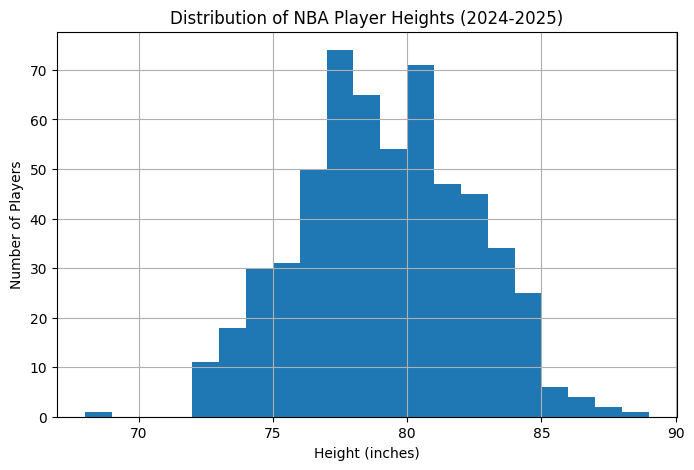

In [7]:

heights = pd.to_numeric(rosters['Height_in'], errors='coerce').dropna()
plt.figure(figsize=(8,5))
plt.hist(heights, bins=range(int(heights.min()), int(heights.max())+2, 1))
plt.title("Distribution of NBA Player Heights (2024-2025)")
plt.xlabel("Height (inches)")
plt.ylabel("Number of Players")
plt.grid(True)
plt.show()


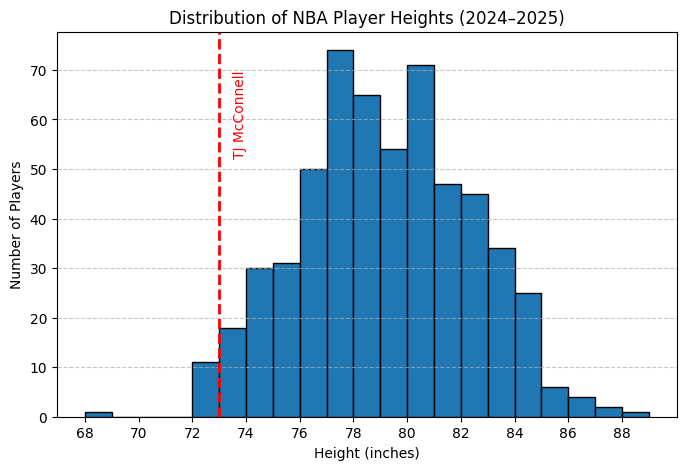

np.int64(73)

In [13]:
# Find TJ McConnell's height by player ID
tj_height = rosters.loc[rosters["Player-additional"] == "mccontj01", "Height_in"].iloc[0]

# Plot histogram with vertical line for TJ McConnell
plt.figure(figsize=(8,5))
plt.hist(heights, bins=range(int(heights.min()), int(heights.max()) + 2, 1), edgecolor='black')
plt.axvline(tj_height, color='red', linestyle='--', linewidth=2)
plt.text(tj_height + 0.5, plt.ylim()[1]*0.9, "TJ McConnell", rotation=90, color='red', va='top')
plt.title("Distribution of NBA Player Heights (2024–2025)")
plt.xlabel("Height (inches)")
plt.ylabel("Number of Players")
plt.xticks(range(int(heights.min()), int(heights.max()) + 1, 2))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

tj_height


## Chart: Distribution of NBA Guard Heights (2024–2025 Season)

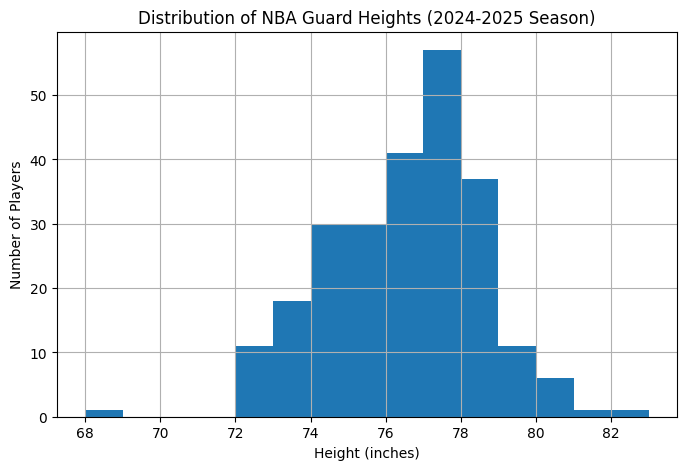

In [8]:

guards = rosters[rosters['Pos'] == 'G'].copy()
g_heights = pd.to_numeric(guards['Height_in'], errors='coerce').dropna()
plt.figure(figsize=(8,5))
plt.hist(g_heights, bins=range(int(g_heights.min()), int(g_heights.max())+2, 1))
plt.title("Distribution of NBA Guard Heights (2024-2025 Season)")
plt.xlabel("Height (inches)")
plt.ylabel("Number of Players")
plt.grid(True)
plt.show()


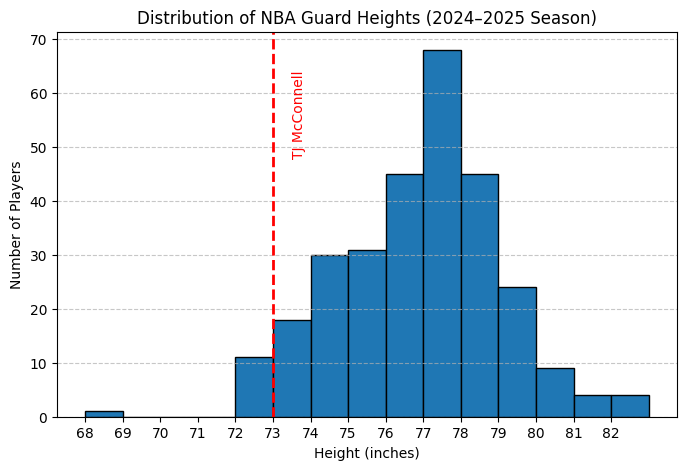

In [14]:
# Filter only guards
guards_df = rosters[rosters["Pos"].str.startswith("G", na=False)]
guards_heights = pd.to_numeric(guards_df["Height_in"], errors="coerce").dropna()

# Get TJ McConnell's height again (same ID)
tj_height = rosters.loc[rosters["Player-additional"] == "mccontj01", "Height_in"].iloc[0]

# Plot histogram for guards
plt.figure(figsize=(8,5))
plt.hist(guards_heights, bins=range(int(guards_heights.min()), int(guards_heights.max()) + 2, 1), edgecolor='black')
plt.axvline(tj_height, color='red', linestyle='--', linewidth=2)
plt.text(tj_height + 0.5, plt.ylim()[1]*0.9, "TJ McConnell", rotation=90, color='red', va='top')
plt.title("Distribution of NBA Guard Heights (2024–2025 Season)")
plt.xlabel("Height (inches)")
plt.ylabel("Number of Players")
plt.xticks(range(int(guards_heights.min()), int(guards_heights.max()) + 1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Chart: Height Vs. Average Shot Distance (2024–2025) — ≥15 MPG

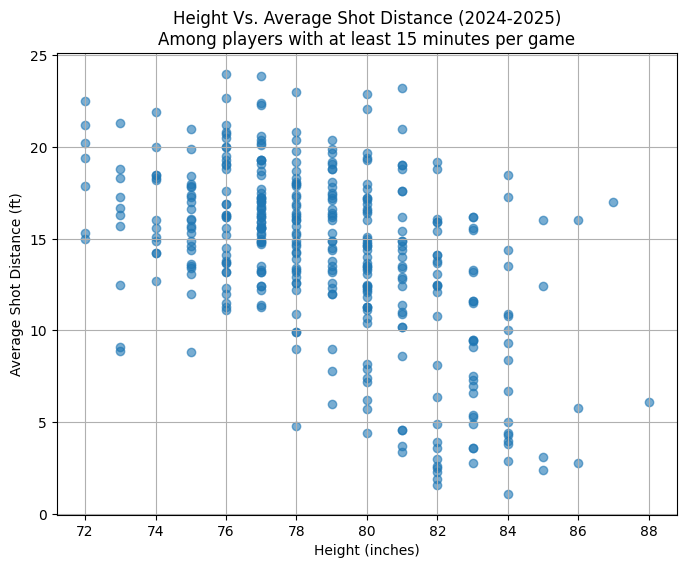

In [9]:

df = total_h.copy()
df['MPG'] = df['MP'] / df['G']
filtered = df[(df['MPG'] >= 15) & df['Height_in'].notna() & df['Dist.'].notna()]
plt.figure(figsize=(8,6))
plt.scatter(filtered['Height_in'], filtered['Dist.'], alpha=0.6)
plt.title("Height Vs. Average Shot Distance (2024-2025)\nAmong players with at least 15 minutes per game")
plt.xlabel("Height (inches)")
plt.ylabel("Average Shot Distance (ft)")
plt.grid(True)
plt.show()


## Chart: Top 10 pure guards by two-point attempt share — 2024–2025 | ≥15 MPG, ≥41 GP

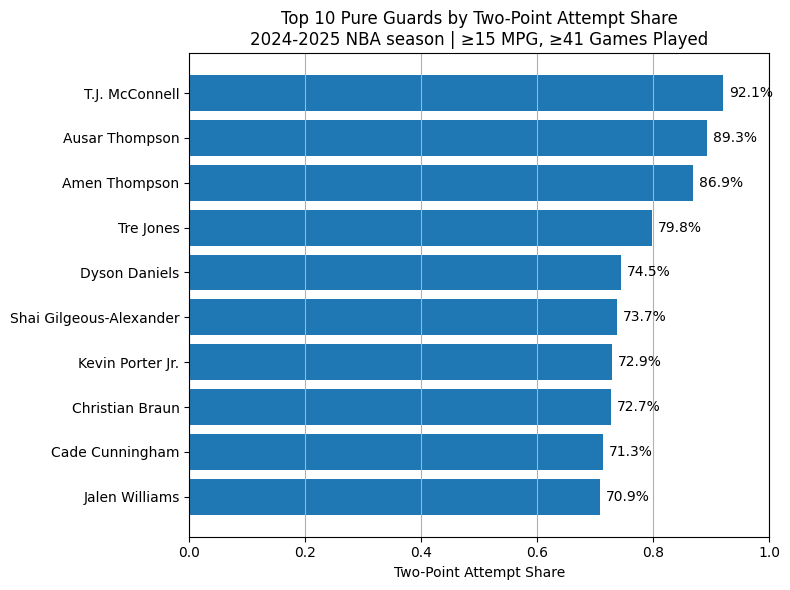

In [10]:

g = rosters[rosters['Pos'] == 'G'].copy()
g['MPG'] = g['MP'] / g['G']
# Ensure numeric
g['2PA'] = pd.to_numeric(g['2PA'], errors='coerce')
g['FGA'] = pd.to_numeric(g['FGA'], errors='coerce')
g = g[(g['MPG'] >= 15) & (g['G'] >= 41) & (g['FGA'] > 0)].copy()
g['2PA_Share'] = g['2PA'] / g['FGA']

top10 = g.sort_values('2PA_Share', ascending=False).head(10)

# Plot
order = top10.sort_values('2PA_Share', ascending=True)
plt.figure(figsize=(8,6))
plt.barh(order['Player'], order['2PA_Share'])
plt.xlabel("Two-Point Attempt Share")
plt.title("Top 10 Pure Guards by Two-Point Attempt Share\n2024-2025 NBA season | ≥15 MPG, ≥41 Games Played")
plt.xlim(0,1)
# Labels
for y,(name,val) in enumerate(zip(order['Player'], order['2PA_Share'])):
    plt.text(val+0.01, y, f"{val:.1%}", va='center')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


## Chart: Pure Guards (≥15 MPG, ≥41 GP) — 2P Attempt share vs 2P FG% | 2024–2025 Season

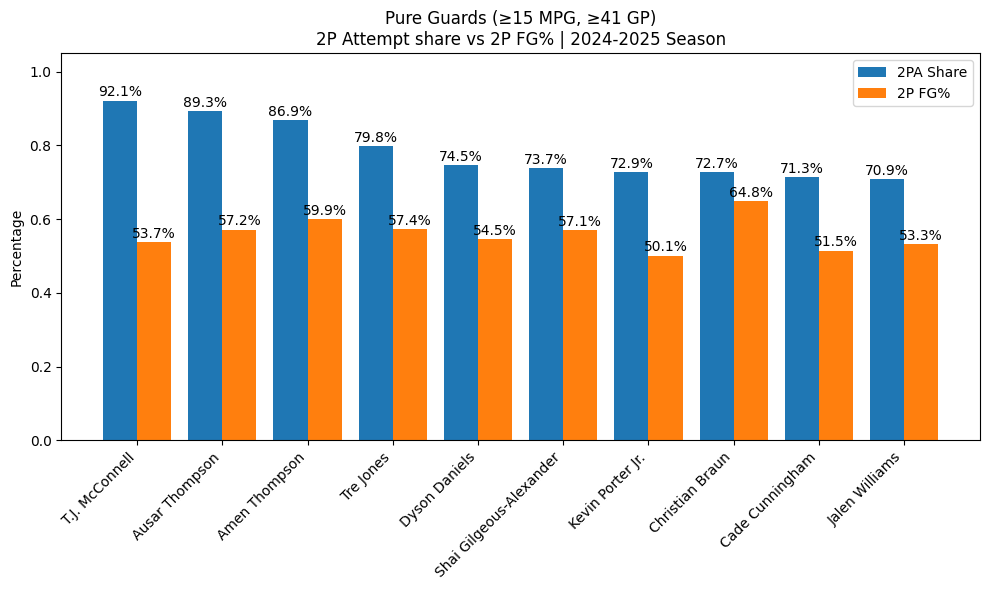

In [11]:

g2 = rosters[rosters['Pos'] == 'G'].copy()
g2['MPG'] = g2['MP'] / g2['G']
# Numerics
g2['2PA'] = pd.to_numeric(g2['2PA'], errors='coerce')
g2['FGA'] = pd.to_numeric(g2['FGA'], errors='coerce')
g2['2P']  = pd.to_numeric(g2['2P'],  errors='coerce')
g2 = g2[(g2['MPG'] >= 15) & (g2['G'] >= 41) & (g2['FGA'] > 0) & (g2['2PA'] > 0)].copy()

g2['2PA_Share'] = g2['2PA'] / g2['FGA']
g2['2P_FG_pct'] = g2['2P'] / g2['2PA']

# Use same top-10 by 2PA share as above
names = list(top10['Player'])
subset = g2[g2['Player'].isin(names)].copy()
subset = subset.set_index('Player').loc[names].reset_index()  # keep order

x = np.arange(len(subset))
width = 0.4
fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width/2, subset['2PA_Share'], width, label='2PA Share')
bars2 = ax.bar(x + width/2, subset['2P_FG_pct'], width, label='2P FG%')
ax.set_ylabel("Percentage")
ax.set_title("Pure Guards (≥15 MPG, ≥41 GP)\n2P Attempt share vs 2P FG% | 2024-2025 Season")
ax.set_xticks(x)
ax.set_xticklabels(subset['Player'], rotation=45, ha='right')
ax.set_ylim(0,1.05)
ax.legend()
for b in list(bars1)+list(bars2):
    h = b.get_height()
    ax.annotate(f"{h:.1%}", (b.get_x()+b.get_width()/2, h), textcoords='offset points', xytext=(0,3), ha='center')
plt.tight_layout()
plt.show()


## Chart: Under 6-1 Guards (≥15 MPG, ≥41 GP since 2000) — 2P share vs 2P FG% (≥90% 2P share, ≥50% 2P%)

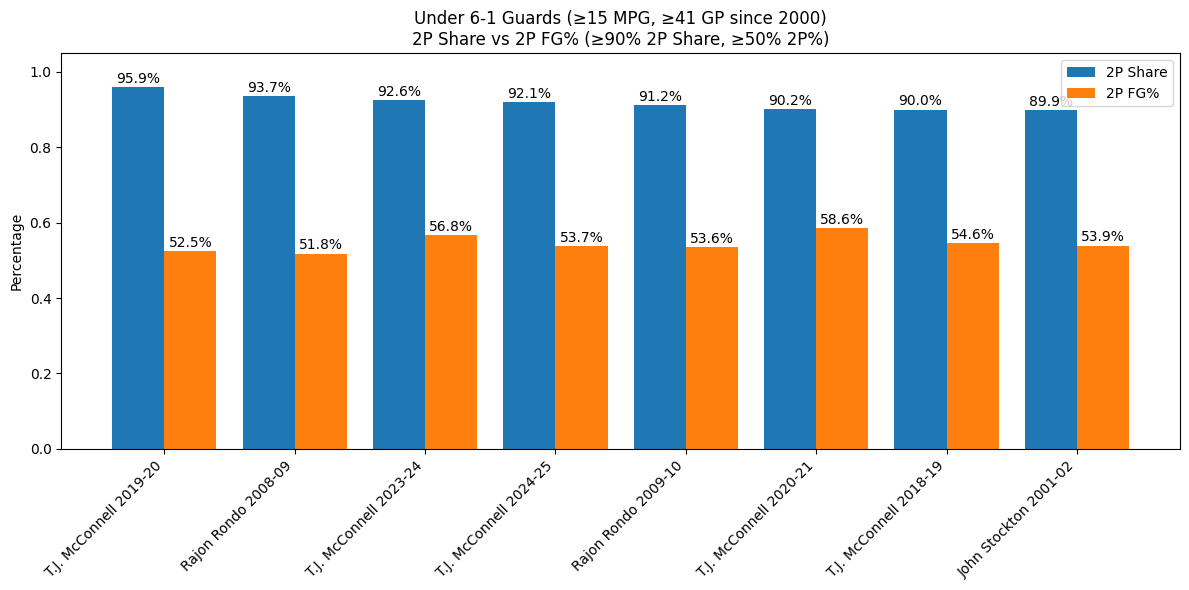

,Player,Season,G,MP/G,2pshare,2P%
0,T.J. McConnell,2019-20,71,18.7,0.959,0.525
1,Rajon Rondo,2008-09,80,33.0,0.937,0.518
2,T.J. McConnell,2023-24,71,18.2,0.926,0.568
3,T.J. McConnell,2024-25,79,17.9,0.921,0.537
4,Rajon Rondo,2009-10,81,36.6,0.912,0.536
5,T.J. McConnell,2020-21,69,26.0,0.902,0.586
6,T.J. McConnell,2018-19,76,19.3,0.900,0.546
7,John Stockton,2001-02,82,31.3,0.899,0.539


In [12]:

df = hist.copy()
# Keep filters
df_f = df[(df['G'] >= 41) & (df['MP/G'] >= 15)].copy()
# use slightly relaxed cutoff to admit 89.9% seasons, but show title as ≥90%
df_f = df_f[(df_f['2pshare'] >= 0.899) & (df_f['2P%'] >= 0.5)].copy()
df_f['2pshare'] = df_f['2pshare'].round(3)
df_f = df_f.sort_values('2pshare', ascending=False)

x = np.arange(len(df_f))
width = 0.4
fig, ax = plt.subplots(figsize=(12,6))
b1 = ax.bar(x - width/2, df_f['2pshare'], width, label='2P Share')
b2 = ax.bar(x + width/2, df_f['2P%'], width, label='2P FG%')
ax.set_ylabel("Percentage")
ax.set_title("Under 6-1 Guards (≥15 MPG, ≥41 GP since 2000)\n2P Share vs 2P FG% (≥90% 2P Share, ≥50% 2P%)")
ax.set_xticks(x)
ax.set_xticklabels(df_f['Player'] + ' ' + df_f['Season'], rotation=45, ha='right')
ax.set_ylim(0,1.05)
ax.legend()
for b in list(b1)+list(b2):
    h = b.get_height()
    ax.annotate(f"{h:.1%}", (b.get_x()+b.get_width()/2, h), textcoords='offset points', xytext=(0,3), ha='center')
plt.tight_layout()
plt.show()

df_f[['Player','Season','G','MP/G','2pshare','2P%']].reset_index(drop=True).head(20)
